In [74]:
%load_ext autoreload
%autoreload 3 --log
%autoreload?

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Docstring:
::

  %autoreload [-p] [-l] [--hide-errors] [mode]

%autoreload => Reload modules automatically

%autoreload or %autoreload now
Reload all modules (except those excluded by %aimport) automatically
now.

%autoreload 0 or %autoreload off
Disable automatic reloading.

%autoreload 1 or %autoreload explicit
Reload only modules imported with %aimport every time before executing
the Python code typed.

%autoreload 2 or %autoreload all
Reload all modules (except those excluded by %aimport) every time
before executing the Python code typed.

%autoreload 3 or %autoreload complete
Same as 2/all, but also but also adds any new objects in the module. See
unit test at IPython/extensions/tests/test_autoreload.py::test_autoload_newly_added_objects

The optional arguments --print and --log control display of autoreload activity. The default
is to act silently; --print (or -p) will print out the names of modules that are being
reloaded, and --log (or -l) outputs them to the log at INFO level.

In [75]:
# !pip install contextily snakeviz

In [76]:
%load_ext snakeviz

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


In [77]:
from stpy.kernels import KernelFunction
from stpy.borel_set import BorelSet, HierarchicalBorelSets
from stpy.point_processes.poisson_rate_estimator import PoissonRateEstimator
import torch
import pandas as pd
import geopandas
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
from scipy.interpolate import griddata
from stpy.point_processes.poisson.poisson import PoissonPointProcess
from sensepy.capture_thompson import CaptureThompson
import time
from utils import *

In [78]:
import torch

if False: # torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_device(device)
else:
    device = torch.device("cpu")
    torch.set_default_device(device)

torch.set_default_dtype(torch.float64)

print(f"Using device: {device}")

Using device: cpu


In [79]:
# Define model hyperparameters

from stpy.kernels import KernelFunction
from stpy.borel_set import BorelSet

gamma = 0.2
kappa = 1.0
d = 2
dt = 30
kernel = KernelFunction(
    kernel_name="squared_exponential", gamma=gamma, kappa=kappa, d=d
)
domain = BorelSet(d, bounds=torch.tensor([[-1.0, 1.0], [-1, 1]]).double())
m = 25
min_intensity = 0.0
max_intensity = 1e7
offset = 0.1
jitter = 1e-7

In [80]:
name = "sensepy/sensepy/benchmarks/data/taxi_data.csv"
Num_data_points = 300
# borel set a square with boundaries [-1,1]^2
D = BorelSet(2, bounds=torch.tensor([[-1.0, 1.0], [-1, 1]]).double())
obs, dt, gdf = get_taxi_data(Num_data_points)
obs = obs.to(device)
data = [(D, obs, dt)]
left, down, right, up = gdf.total_bounds

In [81]:
# Plotting the fitted Map
# get min and max longitude from gdf

def plot_rate(estimator, discretization = 250):
    xtest = D.return_discretization(discretization)
    Map = BorelSet(d=2, bounds=torch.Tensor([[left, right], [down, up]]).double())
    xtest_orig = Map.return_discretization(discretization).cpu().numpy()

    f = estimator.rate_value(xtest)

    xx = xtest_orig[:, 0]
    yy = xtest_orig[:, 1]

    grid_x, grid_y = np.mgrid[min(xx) : max(xx) : 100j, min(yy) : max(yy) : 100j]
    grid_z_f = griddata(
        (xx, yy), f[:, 0].cpu().numpy(), (grid_x, grid_y), method="linear"
    )

    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(ax=ax, color="red", figsize=(10, 10))
    cs = ax.contourf(grid_x, grid_y, grid_z_f, levels=20, alpha=0.5)
    ax.contour(cs, colors="k", alpha=0.5)
    ctx.add_basemap(ax, crs=gdf.crs.to_string())

In [82]:
def plot_basis(estimator, discretization = 250):
    # Plot basis functions

    n = estimator.m

    fig_per_row = 5
    num_rows = int(np.ceil(n / fig_per_row))

    fig, axes = plt.subplots(num_rows, fig_per_row, figsize=(20, num_rows*4))

    grid = D.return_discretization(discretization)

    for i in range(n):

        function_values = estimator.packing.basis_fun(grid, i).cpu().numpy()
        x_coords = grid[:, 0].cpu().numpy()
        y_coords = grid[:, 1].cpu().numpy()

        ax = axes[i // fig_per_row, i % fig_per_row]
        scatter = ax.scatter(
            x_coords,
            y_coords,
            c=function_values,
            cmap="viridis",
        )
        ax.set_title(f"Unit Vector {i+1}")
        ax.set_xlim(domain.bounds[0][0].item(), domain.bounds[0][1].item())
        ax.set_ylim(domain.bounds[1][0].item(), domain.bounds[1][1].item())

    fig.colorbar(
        scatter,
        ax=axes,
        orientation="horizontal",
        fraction=0.02,
        pad=0.1,
        label="Function Value",
    )
    plt.show()

In [ ]:
from stpy.point_processes.poisson_rate_estimator import PoissonRateEstimator
from stpy.borel_set import HierarchicalBorelSets

estimator = PoissonRateEstimator(
    HierarchicalBorelSets(d=2, interval=[(-1, 1), (-1, 1)], levels=8),
    d=2,
    kernel=kernel,
    max_intensity=max_intensity,
    min_intensity=min_intensity,
    basis_size_per_dim=m,
    langevine_sampling_steps=200,
    optimization_library="torch",
    use_anchors=False,
    basis="optimal-positive",
    samples_nystrom=500,
    roi=obs,
    memory_limit=1,
    device=device
)

Optimal basis with arbitrary dimension, namely d = 2
Starting optimal basis construction, with m = 25


Burn-In: 100%|██████████| 30/30 [00:01<00:00, 16.12it/s]
total number of velocity samples: 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1: 
sampling: 100%|██████████| 500/500 [00:29<00:00, 16.98it/s]
total number of velocity samples: 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

Optimal basis constructed.
Precomputation finished.


In [9]:
estimator.load_data(data)

nodes of functions torch.Size([25, 2])


In [10]:
estimator.fit_gp()

CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH


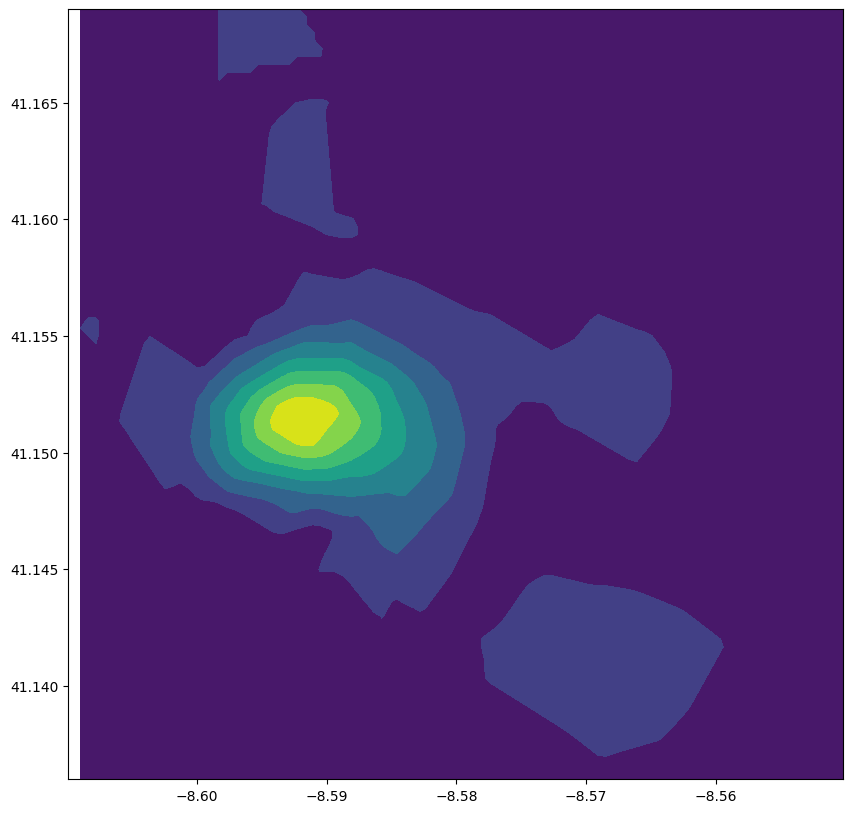

In [58]:
render_resolution = 100


x_world_clipped = np.linspace(-8.609, -8.55, render_resolution)
y_world_clipped = np.linspace(41.136, 41.169, render_resolution)
X, Y = np.meshgrid(x_world_clipped, y_world_clipped)

x = torch.linspace(-1, 1, render_resolution)
y = torch.linspace(-1, 1, render_resolution)
x, y = torch.meshgrid(x, y, indexing="ij")
roi_render = torch.stack([x.flatten(), y.flatten()], dim=-1).to(device)
Z = estimator.rate_value(roi_render)
Z = Z.cpu().numpy().reshape(render_resolution, render_resolution)

fig, ax = plt.subplots(figsize=(10, 10))
ax.contourf(
    X.flatten().reshape(render_resolution, render_resolution),
    Y.flatten().reshape(render_resolution, render_resolution),
    Z,
    cmap="viridis",
)
ax.set_xlim(-8.6099445, -8.5501575)
# ax.set_ylim(-1, 1)
plt.show()

In [53]:
X.shape

(100, 100)

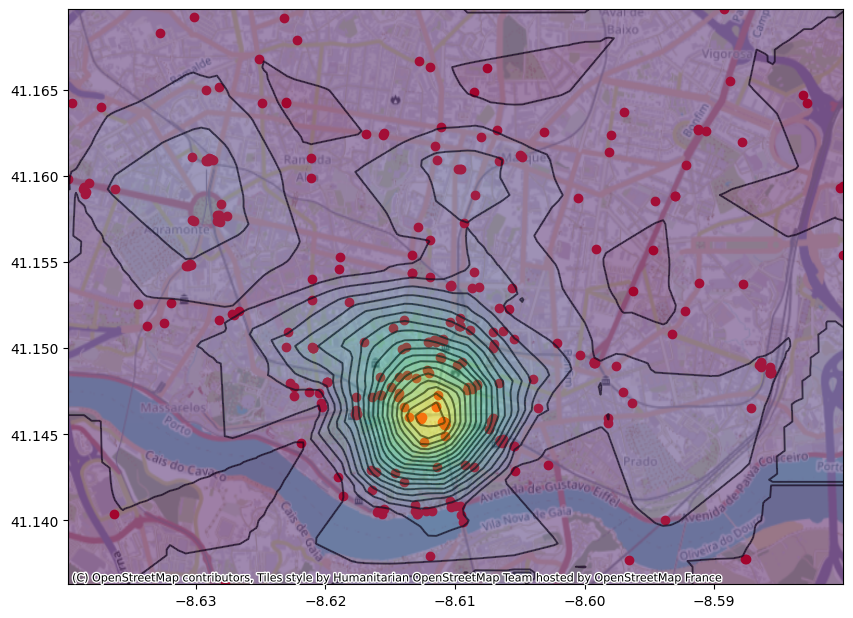

In [34]:
xtest = D.return_discretization(100)
Map = BorelSet(d=2, bounds=torch.Tensor([[left, right], [down, up]]).double())
xtest_orig = Map.return_discretization(100).cpu().numpy()

f = estimator.rate_value(xtest)

xx = xtest_orig[:, 0]
yy = xtest_orig[:, 1]

grid_x, grid_y = np.mgrid[min(xx) : max(xx) : 100j, min(yy) : max(yy) : 100j]
grid_z_f = griddata(
    (xx, yy), f[:, 0].cpu().numpy(), (grid_x, grid_y), method="linear"
)

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color="red", figsize=(10, 10))
cs = ax.contourf(grid_x, grid_y, grid_z_f, levels=20, alpha=0.5)
ax.contour(cs, colors="k", alpha=0.5)
ctx.add_basemap(ax, crs=gdf.crs.to_string())

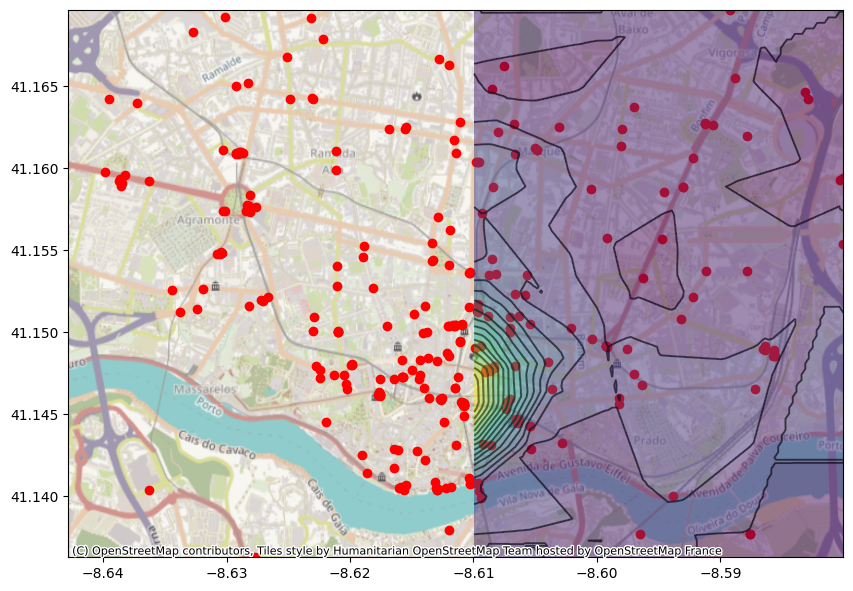

In [73]:
x = torch.linspace(0, 1, render_resolution)
y = torch.linspace(-1, 1, render_resolution)
x, y = torch.meshgrid(x, y, indexing="ij")
roi_render = torch.stack([x.flatten(), y.flatten()], dim=-1).to(device)

Map = BorelSet(d=2, bounds=torch.Tensor([[left + (right - left) / 2, right], [down, up]]).double())
xtest_orig = Map.return_discretization(100).cpu().numpy()

x_orig = np.linspace(left + (right - left) / 2, right, render_resolution)
y_orig = np.linspace(down, up, render_resolution)
x, y = np.meshgrid(x_orig, y_orig, indexing="ij")

f = estimator.rate_value(roi_render)

xx = xtest_orig[:, 0]
yy = xtest_orig[:, 1]

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color="red", figsize=(10, 10))
cs = ax.contourf(
    x,
    y,
    f.reshape(100, 100),
    levels=20,
    alpha=0.5,
)
ax.contour(cs, colors="k", alpha=0.5)
ctx.add_basemap(ax, crs=gdf.crs.to_string())

In [69]:
y

array([[41.136282  , 41.136282  , 41.136282  , ..., 41.136282  ,
        41.136282  , 41.136282  ],
       [41.13661945, 41.13661945, 41.13661945, ..., 41.13661945,
        41.13661945, 41.13661945],
       [41.13695691, 41.13695691, 41.13695691, ..., 41.13695691,
        41.13695691, 41.13695691],
       ...,
       [41.16901509, 41.16901509, 41.16901509, ..., 41.16901509,
        41.16901509, 41.16901509],
       [41.16935255, 41.16935255, 41.16935255, ..., 41.16935255,
        41.16935255, 41.16935255],
       [41.16969   , 41.16969   , 41.16969   , ..., 41.16969   ,
        41.16969   , 41.16969   ]])

In [68]:
xx.reshape(100, 100)

array([[-8.6099445 , -8.6099445 , -8.6099445 , ..., -8.6099445 ,
        -8.6099445 , -8.6099445 ],
       [-8.60964255, -8.60964255, -8.60964255, ..., -8.60964255,
        -8.60964255, -8.60964255],
       [-8.60934059, -8.60934059, -8.60934059, ..., -8.60934059,
        -8.60934059, -8.60934059],
       ...,
       [-8.58065491, -8.58065491, -8.58065491, ..., -8.58065491,
        -8.58065491, -8.58065491],
       [-8.58035295, -8.58035295, -8.58035295, ..., -8.58035295,
        -8.58035295, -8.58035295],
       [-8.580051  , -8.580051  , -8.580051  , ..., -8.580051  ,
        -8.580051  , -8.580051  ]])

In [ ]:
render_resolution = 100
x = torch.linspace(0, 1, render_resolution)
y = torch.linspace(-1, 1, render_resolution)
x, y = torch.meshgrid(x, y, indexing="ij")
roi_render = torch.stack([x.flatten(), y.flatten()], dim=-1).to(device)

Z = estimator.rate_value(roi_render)
Z = Z.cpu().numpy().reshape(render_resolution, render_resolution)

fig, ax = plt.subplots(figsize=(10, 10))
ax.contourf(x.cpu(), y.cpu(), Z, cmap="viridis")
ax.set_xlim(0, 2)
ax.set_ylim(-1, 1)
plt.show()

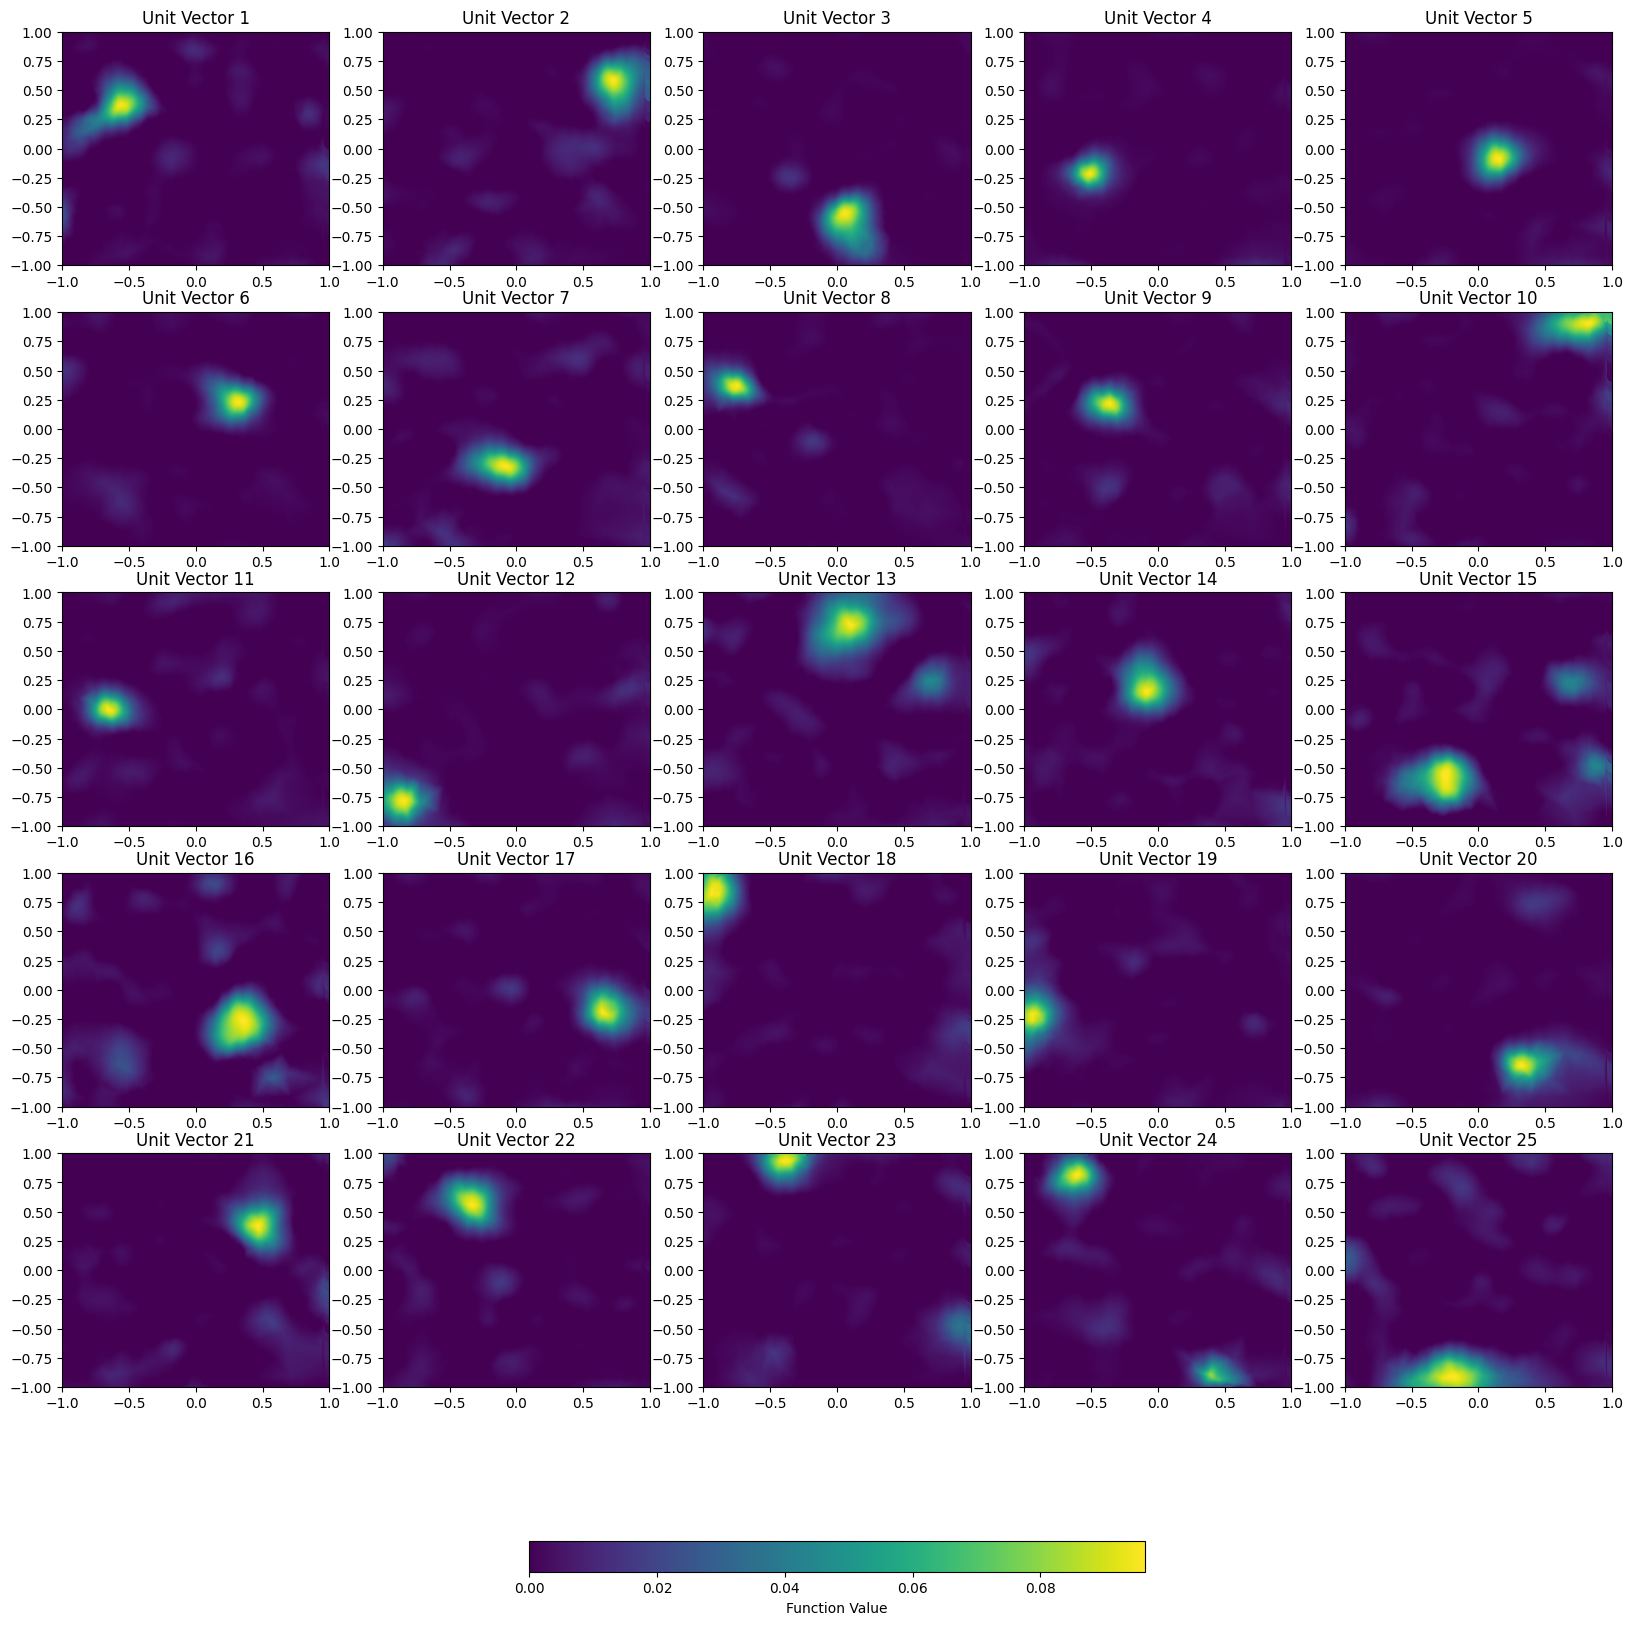

In [23]:
plot_basis(estimator)

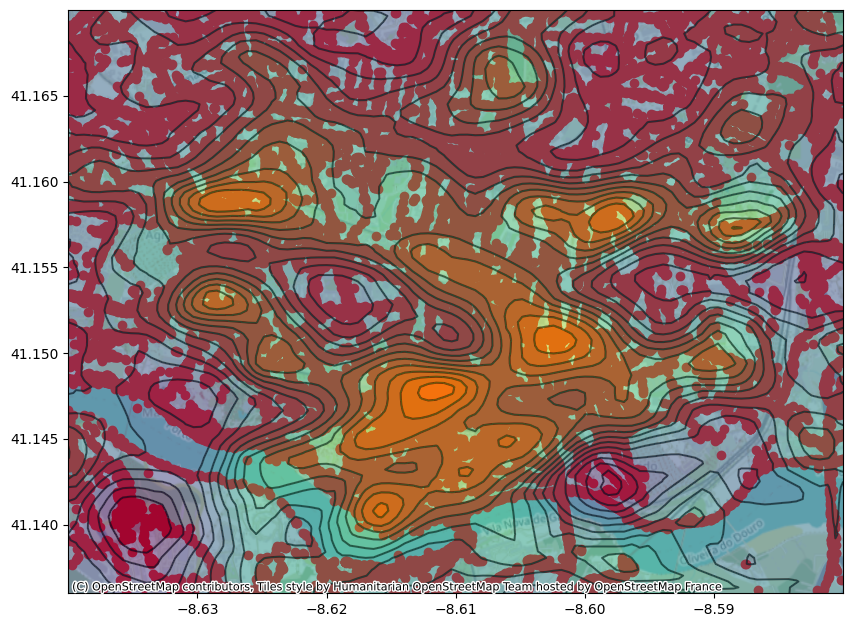

In [24]:
plot_rate(estimator)

In [23]:
roi_resolution = 30
roi_num_basis_functions = 9

sqrt_num_data_points = int(np.floor(np.sqrt(len(estimator.packing.data) / 100)))
print(sqrt_num_data_points)

roi = BorelSet(
    d, bounds=torch.tensor([[-0, 1.0], [0, 1]]).double()
).return_discretization(sqrt_num_data_points)

estimator.packing.add_new_functions(roi, roi_num_basis_functions)
estimator.m = estimator.packing.m
print(estimator.packing.m)

7
Use GPU mode.
 niter=10, loss=78185.79127331047.
 niter=20, loss=76831.84655184853.
 niter=30, loss=76821.9278610207.
 niter=40, loss=76821.17050310776.
 niter=50, loss=76821.01940628183.
 niter=60, loss=76820.98681055476.
 niter=70, loss=76820.97864631408.
 niter=80, loss=76820.97611771361.
 niter=90, loss=76820.97532678473.
    Converged after 90 iteration(s).
34


In [24]:
estimator.load_data(data)  # have to reload since integrals and embeddings changed

nodes of functions torch.Size([34, 2])


/pytorch/aten/src/ATen/native/cuda/IndexKernel.cu:94: operator(): block: [0,0,0], thread: [9,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/IndexKernel.cu:94: operator(): block: [0,0,0], thread: [10,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
estimator.fit_gp()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument tensors in method wrapper_CUDA_cat)

In [19]:
sqrt_num_data_points = int(np.floor(np.sqrt(len(estimator.packing.data) / 100)))
print(sqrt_num_data_points)

roi = BorelSet(
    d, bounds=torch.tensor([[-0, 1.0], [0, 1]]).double()
).return_discretization(sqrt_num_data_points)

%snakeviz -t estimator.packing.refit_existing_functions(roi)


13
Refitting optimal basis


/home/paul/semesterprojekt/.env/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


 
*** Profile stats marshalled to file '/tmp/tmpwyjwu1co'.
Opening SnakeViz in a new tab...
snakeviz web server started on 127.0.0.1:8080; enter Ctrl-C to exit
http://127.0.0.1:8080/snakeviz/%2Ftmp%2Ftmpwyjwu1co


In [35]:
estimator.load_data(data)  # have to reload since integrals and embeddings changed
estimator.fit_gp()

/home/paul/semesterprojekt/.env/lib/python3.10/site-packages/cvxpy/reductions/solvers/conic_solvers/mosek_conif.py:654: UserWarning: 
Using MOSEK constants to specify parameters is deprecated.
Use generic string names instead.
For example, replace mosek.iparam.num_threads with 'MSK_IPAR_NUM_THREADS'

  warnings.warn(__MSK_ENUM_PARAM_DEPRECATION__, UserWarning)


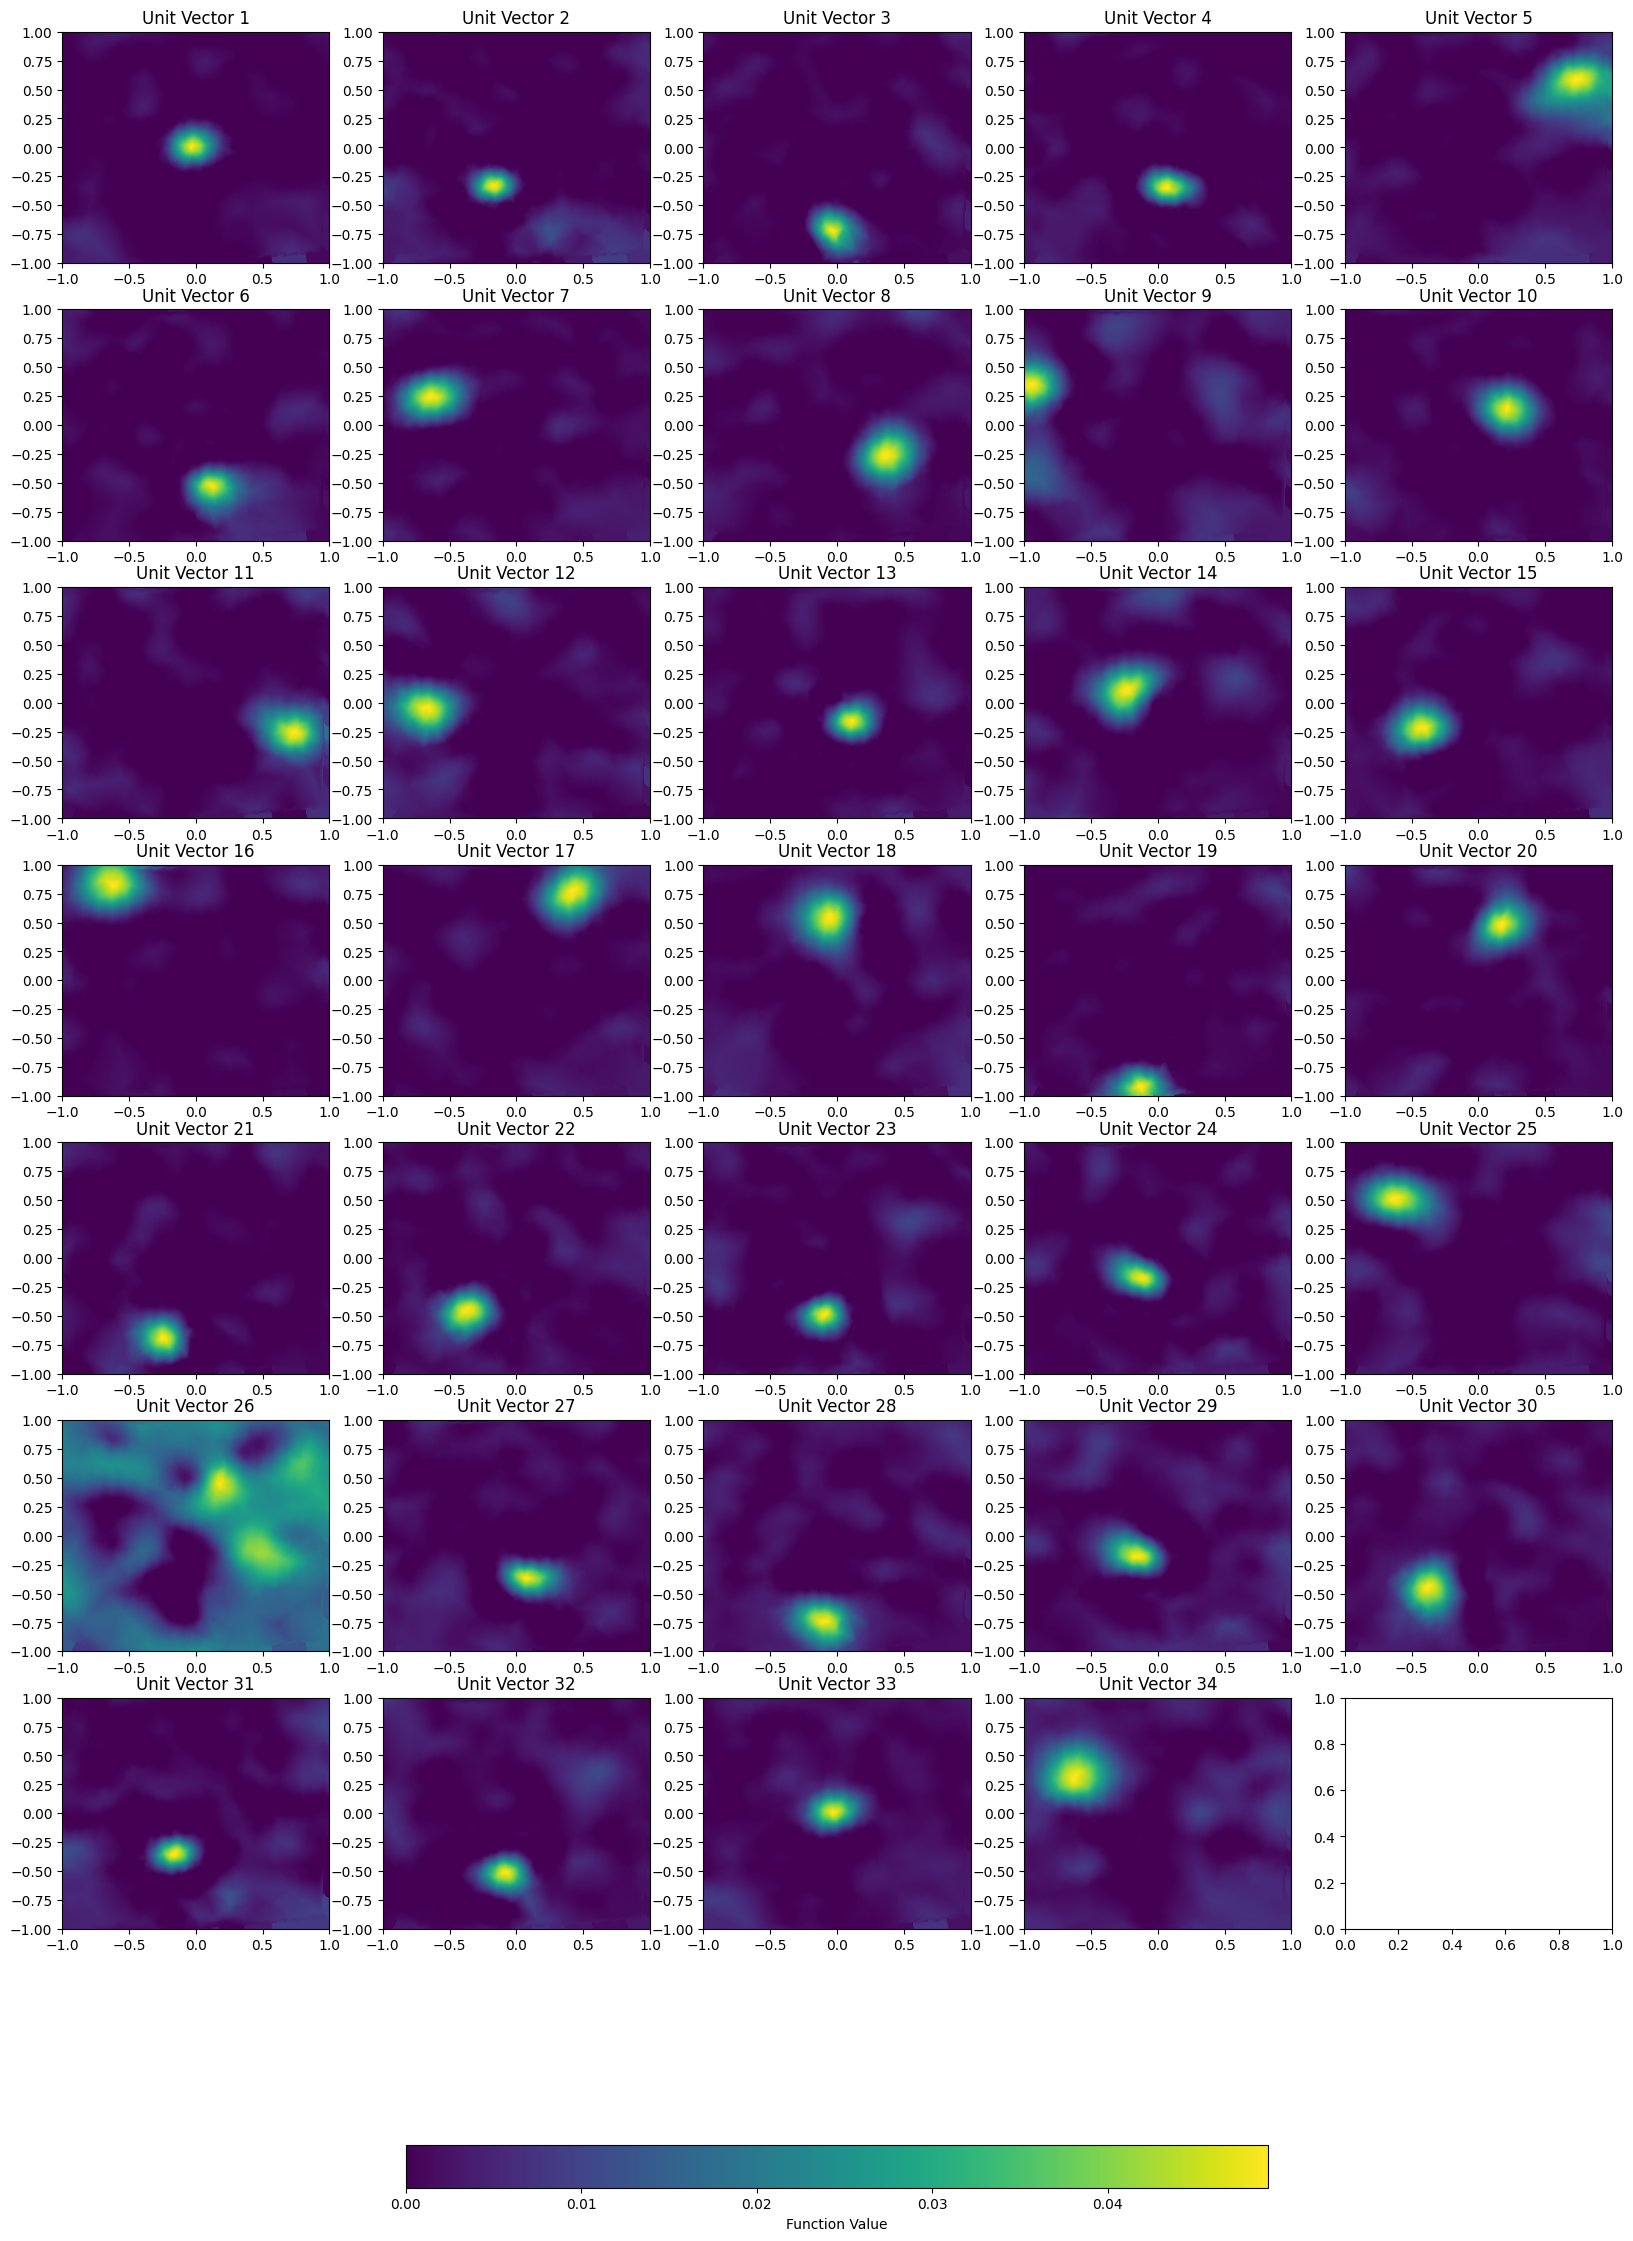

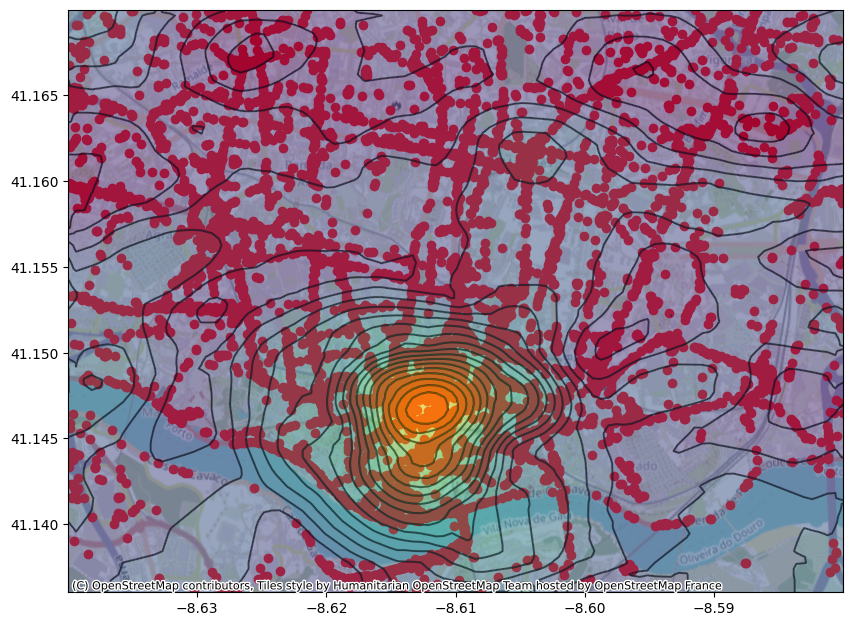

In [62]:
plot_basis(estimator)
plot_rate(estimator)